# Работа с геоданными

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.stats import binned_statistic_2d

Загружаем список регионов и данные с фильтрациями и подклееными регионами с прошлой недели

In [2]:
region = pd.read_csv('regions.csv', delimiter=';')
data = pd.read_csv('tmp.csv', index_col=0)

/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Посмотрим на пример данных и списка регионов

In [3]:
data.head()

,hour,region,hid
0,2016-05-01 00:00:00,1233,0
1,2016-05-01 00:00:00,1180,0
2,2016-05-01 00:00:00,1180,0
3,2016-05-01 00:00:00,1173,0
4,2016-05-01 00:00:00,1130,0


In [4]:
region.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


Посчитаем в разбивке по ячейкам число поездок.

In [5]:
count = [0 for i in range(2500)] 
for item in data[['region']].values:
    count[item[0]] += 1

In [6]:
zero_count = 0
for i in range(2500):
    if count[i] == 0:
        zero_count += 1
print "Количество ячеек, из которых в мае не было совершено ни одной поездки {}".format(zero_count)

Количество ячеек, из которых в мае не было совершено ни одной поездки 1283


Поскольку число поездок варьируется в большом диапазоне (от 0 до 600000), возьмём логарифм от числа поездок.

In [24]:
result = [0 if count[i] == 0 else np.log(count[i]) for i in range(2500)]

In [8]:
X = sorted(set(region.west)) + [-73.70001]
Y = sorted(set(region.south)) + [40.91553]

In [9]:
X, Y = np.meshgrid(X, Y)

In [26]:
values = [[0 for i in range(50)] for j in range(50)]
for i in range(50):
     for j in range(50):
            values[i][j] = result[region[(region.west == X[i][j]) & (region.south == Y[i][j])].region.values[0]-1]

Рисуем статичную карту, ставим точку где находится Empire State Building, раскрашиваем карту по цветам согласно числу поездок.

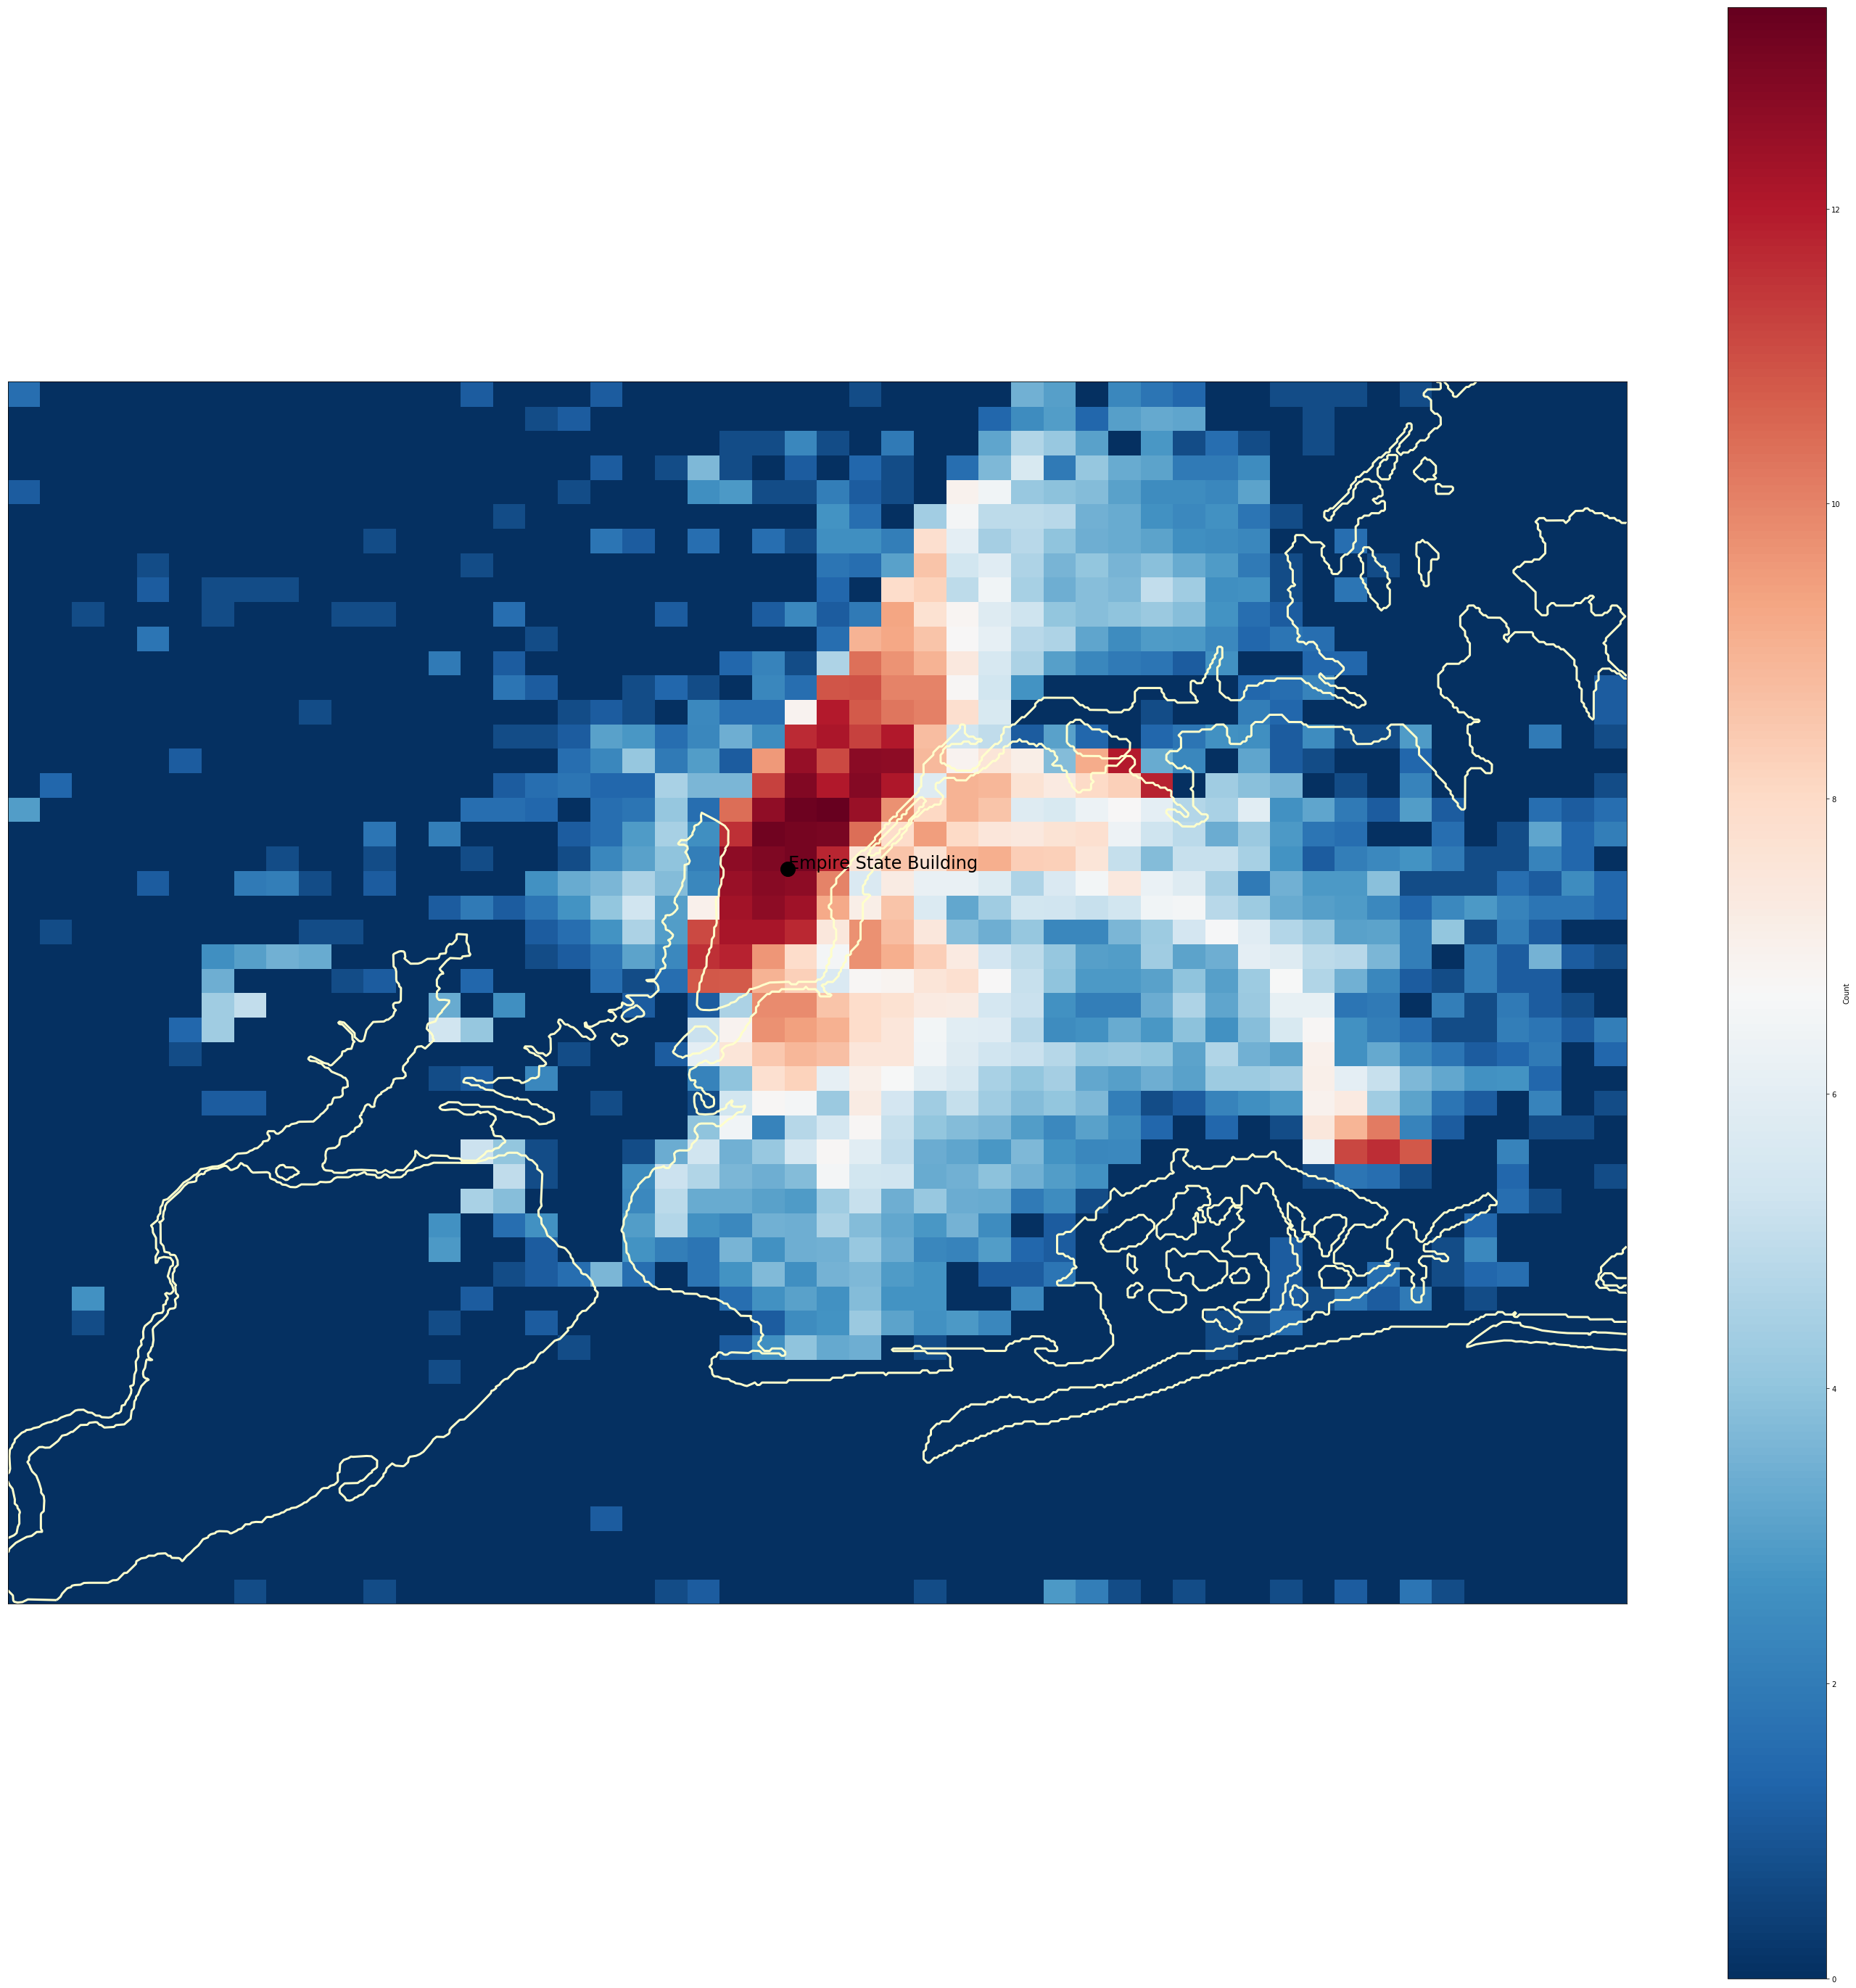

In [27]:
lon_0, lon_1 = -74.25559, -73.70001
lat_0, lat_1 = 40.49612, 40.91553

plt.figure(figsize=(50, 50))
m = Basemap(
    projection='cyl', 
    resolution='f', 
    llcrnrlat=lat_0, 
    urcrnrlat=lat_1, 
    llcrnrlon=lon_0,
    urcrnrlon=lon_1,
    area_thresh = 0.1
)

x, y = m(-73.9878441, 40.7484444)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x + 0.0001, y, 'Empire State Building', fontsize=24);

X = sorted(set(region.west)) + [-73.70001]
Y = sorted(set(region.south)) + [40.91553]
X, Y = np.meshgrid(X, Y)

m.pcolormesh(X, Y, values, latlon=True, cmap='RdBu_r')
m.drawcoastlines(linewidth=3.0, color='#ffffcc')

plt.colorbar(label='Count')

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [28]:
import gmaps
gmaps.configure(api_key="AIz...")

In [50]:
ls_marker = gmaps.marker_layer([(40.689344, -74.044279)])
fig = gmaps.figure(center=(40.689344, -74.044279), zoom_level=11)
fig.add_layer(ls_marker)
fig

Figure()

Посчитаем среднее число в час поезд ок за месяц из каждой ячейки. Всего часов было 744.

In [30]:
count = [0 for _ in range(2500)]
for item in data[['region']].values:
    count[item[0]] += 1/744.0

In [31]:
draw_points = []
weights = []

points = zip(region['south']/2. + region['north']/2.0, region['west']/2. + region['east']/2.0)
for index, item in enumerate(count):
    if item != 0:
        draw_points.append(points[index])
        weights.append(item)

In [48]:
fig = gmaps.figure(center=(40.689344, -74.044279), zoom_level=11)
heatmap = gmaps.heatmap_layer(points, count)
heatmap.max_intensity = 50
fig.add_layer(heatmap)
fig

Figure()

Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [33]:
not_empty_cell = sum(1 for item in count if item >= 5)
print "Число ячеек из которых было в среднем было не менее 5 поездок в час {}".format(not_empty_cell)

Число ячеек из которых было в среднем было не менее 5 поездок в час 102
